Gradient Boosted Decision Tress

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt


Filtering out initial chaotic entries

In [2]:
# Load the CSV file
file_path = "simulation_results.csv"  # Replace with your file path
df = pd.read_csv(file_path)

# Remove rows where the time column is 0, 1, or 60
filtered_df = df[~df['time'].isin([0, 1, 60])]

# # Save the filtered DataFrame to a new CSV file
# filtered_file_path = "filtered_simulation_results.csv"
# filtered_df.to_csv(filtered_file_path, index=False)

# print(f"Filtered file saved to: {filtered_file_path}")

df = filtered_df

In [4]:
# # Load dataset
# file_path = "simulation_results.csv"
# simulation_data = pd.read_csv(file_path)

# Example: using simulation_data = df as mentioned
# simulation_data = pd.read_csv("simulation_results.csv")
simulation_data = df

# Split the dataset into features (X) and target variables (y)
X = simulation_data.drop(columns=["volAverage(T)", "volAverage(Bu)"])
y_temp = simulation_data["volAverage(T)"]

# Bin the continuous target into categories for stratification
# We use quantiles (for example, 10 bins). Adjust q as needed.
num_bins = 10
y_temp_bins = pd.qcut(y_temp, q=num_bins, duplicates='drop', labels=False)

# Train-validation-test split: 80%-10%-10% with stratification
X_train, X_temp, y_train_temp, y_temp_temp, y_bins_train, y_bins_temp = train_test_split(
    X, y_temp, y_temp_bins, test_size=0.2, random_state=42, stratify=y_temp_bins
)

X_val, X_test, y_val, y_test, y_bins_val, y_bins_test = train_test_split(
    X_temp, y_temp_temp, y_bins_temp, test_size=0.5, random_state=42, stratify=y_bins_temp
)



In [ ]:
def train_and_evaluate_model_with_tuning(model_name, model_class, param_grid, X_train, y_train, X_val, y_val):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    train_losses, val_losses = [], []
    best_model = None
    best_rmse = float('inf')
    best_params = None
    evals_result = None

    # We'll use X_test, y_test from outer scope for eval_set logging. 
    # Ensure X_test and y_test are defined before calling this function.
    global X_test, y_test
    
    for train_index, val_index in kf.split(X_train):
        X_t, X_v = X_train.iloc[train_index], X_train.iloc[val_index]
        y_t, y_v = y_train.iloc[train_index], y_train.iloc[val_index]
        
        # Hyperparameter tuning using GridSearchCV
        base_model = model_class()
        grid_search = GridSearchCV(
            estimator=base_model,
            param_grid=param_grid,
            scoring='neg_root_mean_squared_error',
            cv=3,
            verbose=0,
            n_jobs=-1
        )
        grid_search.fit(X_t, y_t)
        fold_best_params = grid_search.best_params_

        # Update model with best params and retrain
        # We add the test set to eval_set for visualization only.
        if model_name == "LightGBM":
            model = model_class(**fold_best_params)
            model.fit(
                X_t, y_t,
                eval_set=[(X_t, y_t), (X_test, y_test), (X_v, y_v)],
                eval_names=["train", "test", "valid"],
                eval_metric="rmse",
                callbacks=[lgb.early_stopping(5)]
            )
            fold_evals_result = model.evals_result_

        elif model_name == "XGBoost":
            fold_best_params["eval_metric"] = "rmse"
            model = model_class(**fold_best_params, early_stopping_rounds=5)
            model.fit(
                X_t, y_t,
                eval_set=[(X_t, y_t), (X_test, y_test), (X_v, y_v)],
                # For XGBoost: validation_0 = train, validation_1 = test, validation_2 = valid
                verbose=False
            )
            fold_evals_result = model.evals_result()

        # Evaluate training and validation performance on the fold
        y_t_pred = model.predict(X_t)
        y_v_pred = model.predict(X_v)
        train_loss = root_mean_squared_error(y_t, y_t_pred)
        val_loss = root_mean_squared_error(y_v, y_v_pred)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Keep track of the best model across folds based on validation loss
        if val_loss < best_rmse:
            best_rmse = val_loss
            best_model = model
            best_params = fold_best_params
            evals_result = fold_evals_result

    # Final evaluation on the validation set with the best model
    y_val_pred = best_model.predict(X_val)
    final_val_rmse = root_mean_squared_error(y_val, y_val_pred)

    return {
        "model": best_model,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "final_val_rmse": final_val_rmse,
        "best_params": best_params,
        "evals_result": evals_result
    }

# Hyperparameter grids
lgb_param_grid = {
    "num_leaves": [20, 31, 40],
    "learning_rate": [0.1, 0.05, 0.01],
    "n_estimators": [50, 100, 200]
}
xgb_param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.1, 0.05, 0.01],
    "n_estimators": [50, 100, 200]
}

# Train and evaluate models with hyperparameter tuning
lgb_results = train_and_evaluate_model_with_tuning("LightGBM", lgb.LGBMRegressor, lgb_param_grid, X_train, y_train, X_val, y_val)
xgb_results = train_and_evaluate_model_with_tuning("XGBoost", xgb.XGBRegressor, xgb_param_grid, X_train, y_train, X_val, y_val)

# Plot Average Losses Across Folds
plt.figure(figsize=(8, 5))
plt.plot(lgb_results["train_losses"], label="LightGBM Training Loss", linestyle="--")
plt.plot(lgb_results["val_losses"], label="LightGBM Validation Loss", linestyle="--")
plt.plot(xgb_results["train_losses"], label="XGBoost Training Loss", linestyle="-")
plt.plot(xgb_results["val_losses"], label="XGBoost Validation Loss", linestyle="-")
plt.xlabel("Cross-Validation Fold")
plt.ylabel("RMSE")
plt.title("Average Losses Across Folds for LightGBM and XGBoost")
plt.legend()
plt.grid()
plt.show()

# Plot Train, Test, and Validation Loss Across Epochs for the Best Models
plt.figure(figsize=(8, 5))

# LightGBM evals_result
if lgb_results["evals_result"] is not None:
    lgb_epochs_train = lgb_results["evals_result"]["train"]["rmse"]
    lgb_epochs_test = lgb_results["evals_result"]["test"]["rmse"]
    lgb_epochs_val = lgb_results["evals_result"]["valid"]["rmse"]
    plt.plot(lgb_epochs_train, label="LightGBM Train RMSE", linestyle='--', color='blue')
    plt.plot(lgb_epochs_test, label="LightGBM Test RMSE", linestyle=':', color='blue')
    plt.plot(lgb_epochs_val, label="LightGBM Valid RMSE", linestyle='-', color='blue')

# XGBoost evals_result
if xgb_results["evals_result"] is not None:
    xgb_epochs_train = xgb_results["evals_result"]["validation_0"]["rmse"]
    xgb_epochs_test = xgb_results["evals_result"]["validation_1"]["rmse"]
    xgb_epochs_val = xgb_results["evals_result"]["validation_2"]["rmse"]
    plt.plot(xgb_epochs_train, label="XGBoost Train RMSE", linestyle='--', color='orange')
    plt.plot(xgb_epochs_test, label="XGBoost Test RMSE", linestyle=':', color='orange')
    plt.plot(xgb_epochs_val, label="XGBoost Valid RMSE", linestyle='-', color='orange')

plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.title("Train, Test, and Validation Loss Across Epochs for the Best Models")
plt.legend()
plt.grid()
plt.show()

# Add Error Bars to Show Variance Across Folds
mean_train_loss_lgb = np.mean(lgb_results["train_losses"])
std_train_loss_lgb = np.std(lgb_results["train_losses"])
mean_val_loss_lgb = np.mean(lgb_results["val_losses"])
std_val_loss_lgb = np.std(lgb_results["val_losses"])

mean_train_loss_xgb = np.mean(xgb_results["train_losses"])
std_train_loss_xgb = np.std(xgb_results["train_losses"])
mean_val_loss_xgb = np.mean(xgb_results["val_losses"])
std_val_loss_xgb = np.std(xgb_results["val_losses"])

plt.figure(figsize=(8, 5))
plt.errorbar(["LGB Train", "LGB Val"], [mean_train_loss_lgb, mean_val_loss_lgb], 
             yerr=[std_train_loss_lgb, std_val_loss_lgb], fmt="o", label="LightGBM")
plt.errorbar(["XGB Train", "XGB Val"], [mean_train_loss_xgb, mean_val_loss_xgb], 
             yerr=[std_train_loss_xgb, std_val_loss_xgb], fmt="o", label="XGBoost")
plt.ylabel("RMSE")
plt.title("Loss with Variance Across Folds")
plt.legend()
plt.grid()
plt.show()

# Final Test Evaluation
lgb_test_pred = lgb_results["model"].predict(X_test)
xgb_test_pred = xgb_results["model"].predict(X_test)

test_results = {
    "LightGBM": {
        "RMSE": root_mean_squared_error(y_test, lgb_test_pred),
        "MAE": mean_absolute_error(y_test, lgb_test_pred),
        "R2": r2_score(y_test, lgb_test_pred)
    },
    "XGBoost": {
        "RMSE": root_mean_squared_error(y_test, xgb_test_pred),
        "MAE": mean_absolute_error(y_test, xgb_test_pred),
        "R2": r2_score(y_test, xgb_test_pred)
    }
}

# Display test results
test_results_df = pd.DataFrame(test_results).T
print("Test Results:")
print(test_results_df)


To test the above code with a small dataset

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[61]	valid_0's rmse: 0.430662	valid_0's l2: 0.18547
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[94]	valid_0's rmse: 0.410218	valid_0's l2: 0.168278
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[56]	valid_0's rmse: 0.532982	valid_0's l2: 0.28407
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[163]	valid_0's rmse: 0.303991	valid_0's l2: 0.0924105
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[44]	valid_0's rmse: 0.40026	valid_0's l2: 0.160208


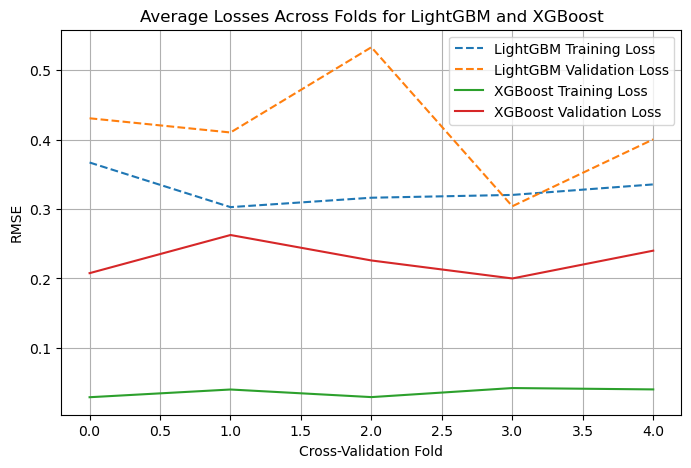

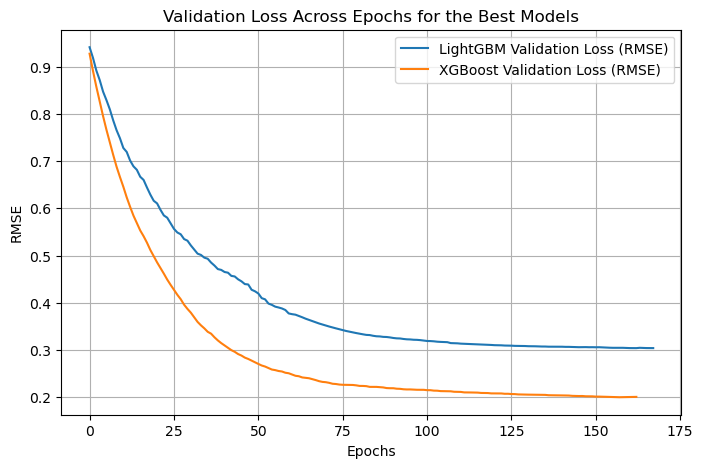

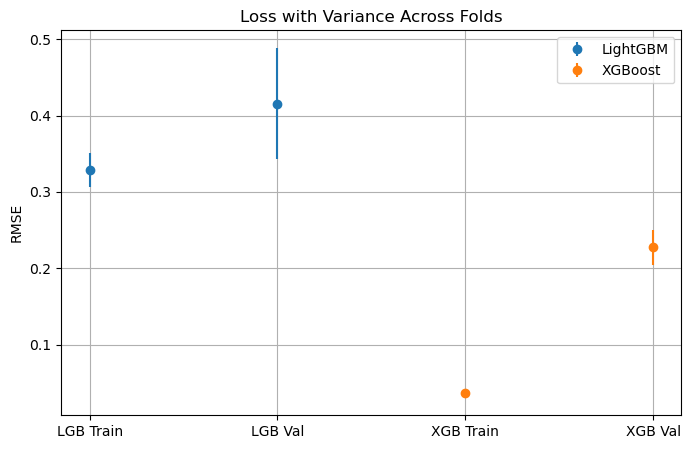

Test Results:
              RMSE       MAE        R2
LightGBM  0.432658  0.319813  0.847042
XGBoost   0.251660  0.186042  0.948250


In [20]:

# Create a synthetic dataset
np.random.seed(42)
X_synthetic = pd.DataFrame({
    "feature1": np.random.rand(100),
    "feature2": np.random.rand(100),
    "feature3": np.random.rand(100)
})
y_synthetic = X_synthetic["feature1"] * 3 + X_synthetic["feature2"] * 2 + np.random.normal(0, 0.1, 100)

# Train-validation-test split
X_train, X_temp, y_train, y_temp = train_test_split(X_synthetic, y_synthetic, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

def train_and_evaluate_model_with_tuning(model_name, model_class, param_grid, X_train, y_train, X_val, y_val):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    train_losses, val_losses = [], []
    best_model = None
    best_rmse = float('inf')
    best_params = None
    evals_result = None
    
    for train_index, val_index in kf.split(X_train):
        X_t, X_v = X_train.iloc[train_index], X_train.iloc[val_index]
        y_t, y_v = y_train.iloc[train_index], y_train.iloc[val_index]
        
        # Hyperparameter tuning using GridSearchCV
        base_model = model_class()
        grid_search = GridSearchCV(
            estimator=base_model,
            param_grid=param_grid,
            scoring='neg_root_mean_squared_error',
            cv=3,
            verbose=0,
            n_jobs=-1
        )
        grid_search.fit(X_t, y_t)
        fold_best_params = grid_search.best_params_

        # Update model with best params and retrain
        if model_name == "LightGBM":
            # LightGBM: early stopping done via callbacks in fit
            model = model_class(**fold_best_params)
            model.fit(
                X_t, y_t,
                eval_set=[(X_v, y_v)],
                eval_metric="rmse",
                callbacks=[lgb.early_stopping(5)]
            )
            fold_evals_result = model.evals_result_
            
        elif model_name == "XGBoost":
            # XGBoost: specify eval_metric and early_stopping_rounds in the constructor
            fold_best_params["eval_metric"] = "rmse"
            model = model_class(**fold_best_params, early_stopping_rounds=5)
            model.fit(
                X_t, y_t,
                eval_set=[(X_v, y_v)],
                verbose=False
            )
            fold_evals_result = model.evals_result()

        # Evaluate training and validation performance
        y_t_pred = model.predict(X_t)
        y_v_pred = model.predict(X_v)

        train_loss = root_mean_squared_error(y_t, y_t_pred)
        val_loss = root_mean_squared_error(y_v, y_v_pred)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Keep track of the best model across folds
        if val_loss < best_rmse:
            best_rmse = val_loss
            best_model = model
            best_params = fold_best_params
            evals_result = fold_evals_result

    # Final evaluation on the validation set with the best model
    y_val_pred = best_model.predict(X_val)
    final_val_rmse = root_mean_squared_error(y_val, y_val_pred)

    return {
        "model": best_model,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "final_val_rmse": final_val_rmse,
        "best_params": best_params,
        "evals_result": evals_result
    }

# Hyperparameter grids
lgb_param_grid = {
    "num_leaves": [20, 31, 40],
    "learning_rate": [0.1, 0.05, 0.01],
    "n_estimators": [50, 100, 200]
}
xgb_param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.1, 0.05, 0.01],
    "n_estimators": [50, 100, 200]
}

# Train and evaluate models with hyperparameter tuning
lgb_results = train_and_evaluate_model_with_tuning("LightGBM", lgb.LGBMRegressor, lgb_param_grid, X_train, y_train, X_val, y_val)
xgb_results = train_and_evaluate_model_with_tuning("XGBoost", xgb.XGBRegressor, xgb_param_grid, X_train, y_train, X_val, y_val)

# 1. Average Losses Across Folds
plt.figure(figsize=(8, 5))
plt.plot(lgb_results["train_losses"], label="LightGBM Training Loss", linestyle="--")
plt.plot(lgb_results["val_losses"], label="LightGBM Validation Loss", linestyle="--")
plt.plot(xgb_results["train_losses"], label="XGBoost Training Loss", linestyle="-")
plt.plot(xgb_results["val_losses"], label="XGBoost Validation Loss", linestyle="-")
plt.xlabel("Cross-Validation Fold")
plt.ylabel("RMSE")
plt.title("Average Losses Across Folds for LightGBM and XGBoost")
plt.legend()
plt.grid()
plt.show()

# 2. Validation Loss Across Epochs for the Best Models
plt.figure(figsize=(8, 5))

# For LightGBM, validation metric is stored under evals_result_["valid_0"]["rmse"]
if lgb_results["evals_result"] is not None and "valid_0" in lgb_results["evals_result"]:
    plt.plot(lgb_results["evals_result"]["valid_0"]["rmse"], label="LightGBM Validation Loss (RMSE)")

# For XGBoost, validation metric is stored under model.evals_result()["validation_0"]["rmse"]
if xgb_results["evals_result"] is not None and "validation_0" in xgb_results["evals_result"]:
    plt.plot(xgb_results["evals_result"]["validation_0"]["rmse"], label="XGBoost Validation Loss (RMSE)")

plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.title("Validation Loss Across Epochs for the Best Models")
plt.legend()
plt.grid()
plt.show()

# 3. Add Error Bars to Show Variance Across Folds
mean_train_loss_lgb = np.mean(lgb_results["train_losses"])
std_train_loss_lgb = np.std(lgb_results["train_losses"])
mean_val_loss_lgb = np.mean(lgb_results["val_losses"])
std_val_loss_lgb = np.std(lgb_results["val_losses"])

mean_train_loss_xgb = np.mean(xgb_results["train_losses"])
std_train_loss_xgb = np.std(xgb_results["train_losses"])
mean_val_loss_xgb = np.mean(xgb_results["val_losses"])
std_val_loss_xgb = np.std(xgb_results["val_losses"])

plt.figure(figsize=(8, 5))
plt.errorbar(["LGB Train", "LGB Val"], [mean_train_loss_lgb, mean_val_loss_lgb], 
             yerr=[std_train_loss_lgb, std_val_loss_lgb], fmt="o", label="LightGBM")
plt.errorbar(["XGB Train", "XGB Val"], [mean_train_loss_xgb, mean_val_loss_xgb], 
             yerr=[std_train_loss_xgb, std_val_loss_xgb], fmt="o", label="XGBoost")
plt.ylabel("RMSE")
plt.title("Loss with Variance Across Folds")
plt.legend()
plt.grid()
plt.show()

# Final Test Evaluation
lgb_test_pred = lgb_results["model"].predict(X_test)
xgb_test_pred = xgb_results["model"].predict(X_test)

test_results = {
    "LightGBM": {
        "RMSE": root_mean_squared_error(y_test, lgb_test_pred),
        "MAE": mean_absolute_error(y_test, lgb_test_pred),
        "R2": r2_score(y_test, lgb_test_pred)
    },
    "XGBoost": {
        "RMSE": root_mean_squared_error(y_test, xgb_test_pred),
        "MAE": mean_absolute_error(y_test, xgb_test_pred),
        "R2": r2_score(y_test, xgb_test_pred)
    }
}

# Display test results
test_results_df = pd.DataFrame(test_results).T
print("Test Results:")
print(test_results_df)


Working ver

c:\Users\iltergo\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[61]	train's rmse: 0.366984	train's l2: 0.134677	test's rmse: 0.322882	test's l2: 0.104253	valid's rmse: 0.430662	valid's l2: 0.18547
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[71]	train's rmse: 0.308127	train's l2: 0.0949424	test's rmse: 0.362319	test's l2: 0.131275	valid's rmse: 0.41285	valid's l2: 0.170445
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[56]	train's rmse: 0.316272	train's l2: 0.100028	test's rmse: 0.365164	test's l2: 0.133345	valid's rmse: 0.532982	valid's l2: 0.28407
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[85]	train's rmse: 0.358522	train's l2: 0.128538	test's rmse: 0.415282	test's l2: 0.172459	valid's rmse: 0.330129	valid's l2: 0.108985
Training until validation scores don't improve for 5 rounds
Early stopping, best i

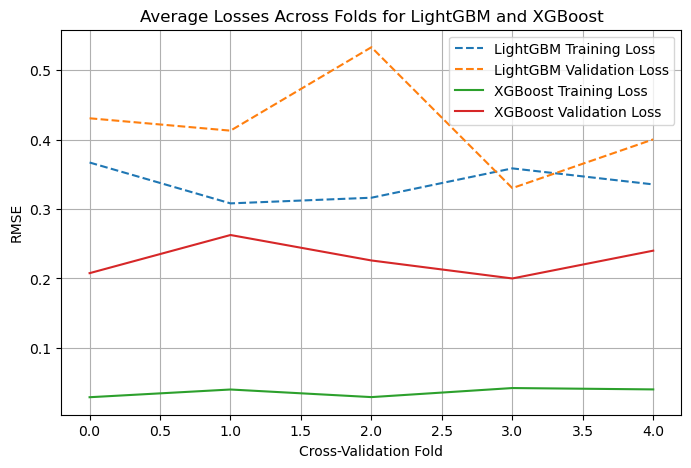

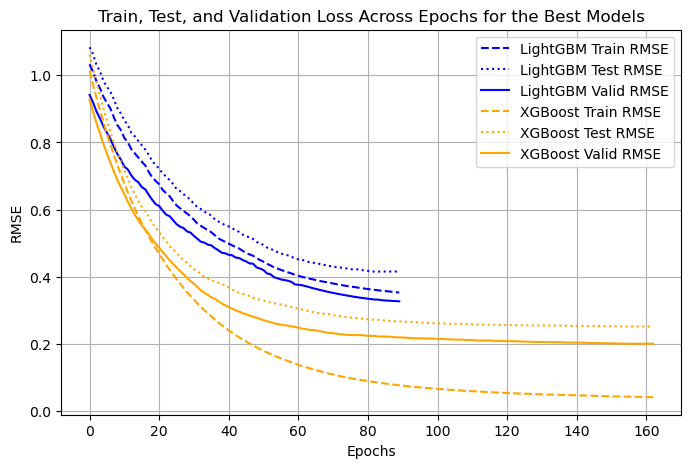

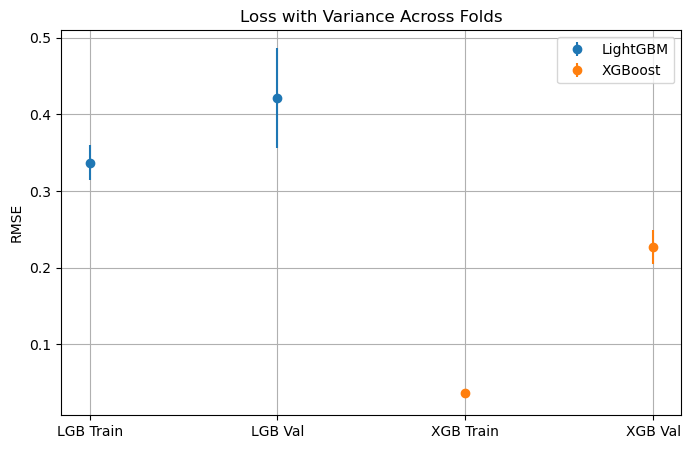

Test Results:
              RMSE       MAE        R2
LightGBM  0.415282  0.323458  0.859081
XGBoost   0.251660  0.186042  0.948250


In [25]:
# Create a synthetic dataset
np.random.seed(42)
X_synthetic = pd.DataFrame({
    "feature1": np.random.rand(100),
    "feature2": np.random.rand(100),
    "feature3": np.random.rand(100)
})
y_synthetic = X_synthetic["feature1"] * 3 + X_synthetic["feature2"] * 2 + np.random.normal(0, 0.1, 100)

# Train-validation-test split
X_train, X_temp, y_train, y_temp = train_test_split(X_synthetic, y_synthetic, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

def train_and_evaluate_model_with_tuning(model_name, model_class, param_grid, X_train, y_train, X_val, y_val):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    train_losses, val_losses = [], []
    best_model = None
    best_rmse = float('inf')
    best_params = None
    evals_result = None
    
    for train_index, val_index in kf.split(X_train):
        X_t, X_v = X_train.iloc[train_index], X_train.iloc[val_index]
        y_t, y_v = y_train.iloc[train_index], y_train.iloc[val_index]
        
        # Hyperparameter tuning using GridSearchCV
        base_model = model_class()
        grid_search = GridSearchCV(
            estimator=base_model,
            param_grid=param_grid,
            scoring='neg_root_mean_squared_error',
            cv=3,
            verbose=0,
            n_jobs=-1
        )
        grid_search.fit(X_t, y_t)
        fold_best_params = grid_search.best_params_

        # Update model with best params and retrain
        # We add the test set to eval_set so we can track test RMSE each epoch.
        # The order: train -> test -> valid. Early stopping will monitor the last dataset (valid) by default.
        if model_name == "LightGBM":
            model = model_class(**fold_best_params)
            model.fit(
                X_t, y_t,
                eval_set=[(X_t, y_t), (X_test, y_test), (X_v, y_v)],
                eval_names=["train", "test", "valid"],
                eval_metric="rmse",
                callbacks=[lgb.early_stopping(5)]
            )
            fold_evals_result = model.evals_result_

        elif model_name == "XGBoost":
            fold_best_params["eval_metric"] = "rmse"
            model = model_class(**fold_best_params, early_stopping_rounds=5)
            model.fit(
                X_t, y_t,
                eval_set=[(X_t, y_t), (X_test, y_test), (X_v, y_v)],
                # XGBoost doesn't support eval_names directly via fit(), 
                # so the results will be in order: validation_0 = train, validation_1 = test, validation_2 = valid
                verbose=False
            )
            fold_evals_result = model.evals_result()

        # Evaluate training and validation performance on the fold
        y_t_pred = model.predict(X_t)
        y_v_pred = model.predict(X_v)
        train_loss = root_mean_squared_error(y_t, y_t_pred)
        val_loss = root_mean_squared_error(y_v, y_v_pred)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Keep track of the best model across folds based on validation loss
        if val_loss < best_rmse:
            best_rmse = val_loss
            best_model = model
            best_params = fold_best_params
            evals_result = fold_evals_result

    # Final evaluation on the validation set with the best model
    y_val_pred = best_model.predict(X_val)
    final_val_rmse = root_mean_squared_error(y_val, y_val_pred)

    return {
        "model": best_model,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "final_val_rmse": final_val_rmse,
        "best_params": best_params,
        "evals_result": evals_result
    }

# Hyperparameter grids
lgb_param_grid = {
    "num_leaves": [20, 31, 40],
    "learning_rate": [0.1, 0.05, 0.01],
    "n_estimators": [50, 100, 200]
}
xgb_param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.1, 0.05, 0.01],
    "n_estimators": [50, 100, 200]
}

# Train and evaluate models with hyperparameter tuning
lgb_results = train_and_evaluate_model_with_tuning("LightGBM", lgb.LGBMRegressor, lgb_param_grid, X_train, y_train, X_val, y_val)
xgb_results = train_and_evaluate_model_with_tuning("XGBoost", xgb.XGBRegressor, xgb_param_grid, X_train, y_train, X_val, y_val)

# 1. Average Losses Across Folds
plt.figure(figsize=(8, 5))
plt.plot(lgb_results["train_losses"], label="LightGBM Training Loss", linestyle="--")
plt.plot(lgb_results["val_losses"], label="LightGBM Validation Loss", linestyle="--")
plt.plot(xgb_results["train_losses"], label="XGBoost Training Loss", linestyle="-")
plt.plot(xgb_results["val_losses"], label="XGBoost Validation Loss", linestyle="-")
plt.xlabel("Cross-Validation Fold")
plt.ylabel("RMSE")
plt.title("Average Losses Across Folds for LightGBM and XGBoost")
plt.legend()
plt.grid()
plt.show()

# 2. Validation Loss (and now Test Loss) Across Epochs for the Best Models
plt.figure(figsize=(8, 5))

# LightGBM evals_result: {"train": {"rmse":[...]}, "test":{"rmse":[...]}, "valid":{"rmse":[...]}}
if lgb_results["evals_result"] is not None:
    lgb_epochs_train = lgb_results["evals_result"]["train"]["rmse"]
    lgb_epochs_test = lgb_results["evals_result"]["test"]["rmse"]
    lgb_epochs_val = lgb_results["evals_result"]["valid"]["rmse"]
    plt.plot(lgb_epochs_train, label="LightGBM Train RMSE", linestyle='--', color='blue')
    plt.plot(lgb_epochs_test, label="LightGBM Test RMSE", linestyle=':', color='blue')
    plt.plot(lgb_epochs_val, label="LightGBM Valid RMSE", linestyle='-', color='blue')

# XGBoost evals_result: {"validation_0": {"rmse":[]}, "validation_1":{"rmse":[]}, "validation_2":{"rmse":[]}}
# According to the order we gave them: validation_0 = train, validation_1 = test, validation_2 = valid
if xgb_results["evals_result"] is not None:
    xgb_epochs_train = xgb_results["evals_result"]["validation_0"]["rmse"]
    xgb_epochs_test = xgb_results["evals_result"]["validation_1"]["rmse"]
    xgb_epochs_val = xgb_results["evals_result"]["validation_2"]["rmse"]
    plt.plot(xgb_epochs_train, label="XGBoost Train RMSE", linestyle='--', color='orange')
    plt.plot(xgb_epochs_test, label="XGBoost Test RMSE", linestyle=':', color='orange')
    plt.plot(xgb_epochs_val, label="XGBoost Valid RMSE", linestyle='-', color='orange')

plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.title("Train, Test, and Validation Loss Across Epochs for the Best Models")
plt.legend()
plt.grid()
plt.show()

# 3. Add Error Bars to Show Variance Across Folds
mean_train_loss_lgb = np.mean(lgb_results["train_losses"])
std_train_loss_lgb = np.std(lgb_results["train_losses"])
mean_val_loss_lgb = np.mean(lgb_results["val_losses"])
std_val_loss_lgb = np.std(lgb_results["val_losses"])

mean_train_loss_xgb = np.mean(xgb_results["train_losses"])
std_train_loss_xgb = np.std(xgb_results["train_losses"])
mean_val_loss_xgb = np.mean(xgb_results["val_losses"])
std_val_loss_xgb = np.std(xgb_results["val_losses"])

plt.figure(figsize=(8, 5))
plt.errorbar(["LGB Train", "LGB Val"], [mean_train_loss_lgb, mean_val_loss_lgb], 
             yerr=[std_train_loss_lgb, std_val_loss_lgb], fmt="o", label="LightGBM")
plt.errorbar(["XGB Train", "XGB Val"], [mean_train_loss_xgb, mean_val_loss_xgb], 
             yerr=[std_train_loss_xgb, std_val_loss_xgb], fmt="o", label="XGBoost")
plt.ylabel("RMSE")
plt.title("Loss with Variance Across Folds")
plt.legend()
plt.grid()
plt.show()

# Final Test Evaluation
lgb_test_pred = lgb_results["model"].predict(X_test)
xgb_test_pred = xgb_results["model"].predict(X_test)

test_results = {
    "LightGBM": {
        "RMSE": root_mean_squared_error(y_test, lgb_test_pred),
        "MAE": mean_absolute_error(y_test, lgb_test_pred),
        "R2": r2_score(y_test, lgb_test_pred)
    },
    "XGBoost": {
        "RMSE": root_mean_squared_error(y_test, xgb_test_pred),
        "MAE": mean_absolute_error(y_test, xgb_test_pred),
        "R2": r2_score(y_test, xgb_test_pred)
    }
}

# Display test results
test_results_df = pd.DataFrame(test_results).T
print("Test Results:")
print(test_results_df)

In [10]:
import lightgbm as lgb
import xgboost as xgb

print(f"LightGBM version: {lgb.__version__}")
print(f"XGBoost version: {xgb.__version__}")



LightGBM version: 4.5.0
XGBoost version: 2.1.3


Trying out stratification and separation of the code:

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[61]	train's rmse: 0.366984	train's l2: 0.134677	test's rmse: 0.322882	test's l2: 0.104253	valid's rmse: 0.430662	valid's l2: 0.18547
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[71]	train's rmse: 0.308127	train's l2: 0.0949424	test's rmse: 0.362319	test's l2: 0.131275	valid's rmse: 0.41285	valid's l2: 0.170445
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[56]	train's rmse: 0.316272	train's l2: 0.100028	test's rmse: 0.365164	test's l2: 0.133345	valid's rmse: 0.532982	valid's l2: 0.28407
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[85]	train's rmse: 0.358522	train's l2: 0.128538	test's rmse: 0.415282	test's l2: 0.172459	valid's rmse: 0.330129	valid's l2: 0.108985
Training until validation scores don't improve for 5 rounds
Early stopping, best i

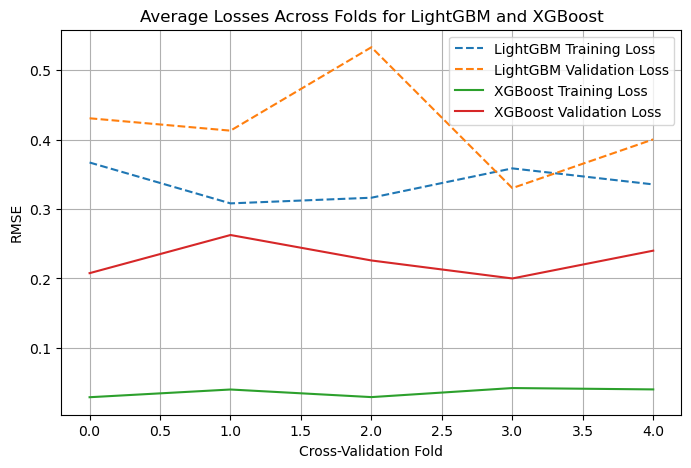

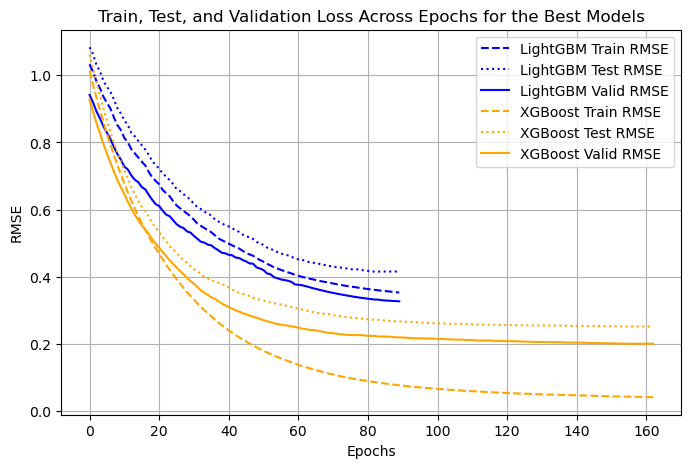

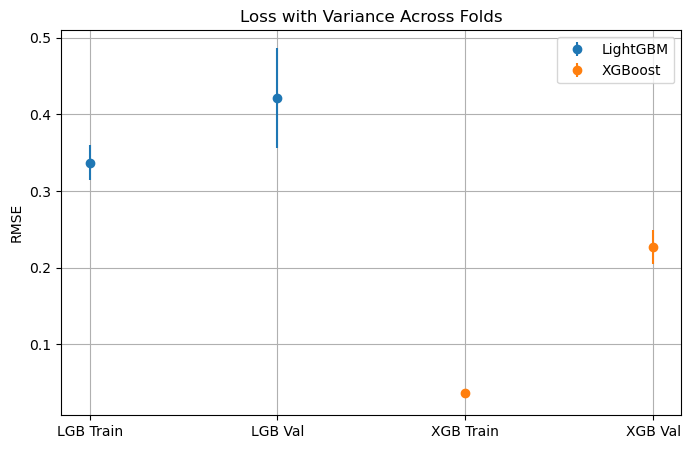

Test Results:
              RMSE       MAE        R2
LightGBM  0.415282  0.323458  0.859081
XGBoost   0.251660  0.186042  0.948250


In [27]:
# Create a synthetic dataset
np.random.seed(42)
X_synthetic = pd.DataFrame({
    "feature1": np.random.rand(100),
    "feature2": np.random.rand(100),
    "feature3": np.random.rand(100)
})
y_synthetic = X_synthetic["feature1"] * 3 + X_synthetic["feature2"] * 2 + np.random.normal(0, 0.1, 100)

# Train-validation-test split
X_train, X_temp, y_train, y_temp = train_test_split(X_synthetic, y_synthetic, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

def train_and_evaluate_model_with_tuning(model_name, model_class, param_grid, X_train, y_train, X_val, y_val):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    train_losses, val_losses = [], []
    best_model = None
    best_rmse = float('inf')
    best_params = None
    evals_result = None

    # We'll use X_test, y_test from outer scope for eval_set logging. 
    # Ensure X_test and y_test are defined before calling this function.
    global X_test, y_test
    
    for train_index, val_index in kf.split(X_train):
        X_t, X_v = X_train.iloc[train_index], X_train.iloc[val_index]
        y_t, y_v = y_train.iloc[train_index], y_train.iloc[val_index]
        
        # Hyperparameter tuning using GridSearchCV
        base_model = model_class()
        grid_search = GridSearchCV(
            estimator=base_model,
            param_grid=param_grid,
            scoring='neg_root_mean_squared_error',
            cv=3,
            verbose=0,
            n_jobs=-1
        )
        grid_search.fit(X_t, y_t)
        fold_best_params = grid_search.best_params_

        # Update model with best params and retrain
        # We add the test set to eval_set for visualization only.
        if model_name == "LightGBM":
            model = model_class(**fold_best_params)
            model.fit(
                X_t, y_t,
                eval_set=[(X_t, y_t), (X_test, y_test), (X_v, y_v)],
                eval_names=["train", "test", "valid"],
                eval_metric="rmse",
                callbacks=[lgb.early_stopping(5)]
            )
            fold_evals_result = model.evals_result_

        elif model_name == "XGBoost":
            fold_best_params["eval_metric"] = "rmse"
            model = model_class(**fold_best_params, early_stopping_rounds=5)
            model.fit(
                X_t, y_t,
                eval_set=[(X_t, y_t), (X_test, y_test), (X_v, y_v)],
                # For XGBoost: validation_0 = train, validation_1 = test, validation_2 = valid
                verbose=False
            )
            fold_evals_result = model.evals_result()

        # Evaluate training and validation performance on the fold
        y_t_pred = model.predict(X_t)
        y_v_pred = model.predict(X_v)
        train_loss = root_mean_squared_error(y_t, y_t_pred)
        val_loss = root_mean_squared_error(y_v, y_v_pred)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Keep track of the best model across folds based on validation loss
        if val_loss < best_rmse:
            best_rmse = val_loss
            best_model = model
            best_params = fold_best_params
            evals_result = fold_evals_result

    # Final evaluation on the validation set with the best model
    y_val_pred = best_model.predict(X_val)
    final_val_rmse = root_mean_squared_error(y_val, y_val_pred)

    return {
        "model": best_model,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "final_val_rmse": final_val_rmse,
        "best_params": best_params,
        "evals_result": evals_result
    }

# Hyperparameter grids
lgb_param_grid = {
    "num_leaves": [20, 31, 40],
    "learning_rate": [0.1, 0.05, 0.01],
    "n_estimators": [50, 100, 200]
}
xgb_param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.1, 0.05, 0.01],
    "n_estimators": [50, 100, 200]
}

# Train and evaluate models with hyperparameter tuning
lgb_results = train_and_evaluate_model_with_tuning("LightGBM", lgb.LGBMRegressor, lgb_param_grid, X_train, y_train, X_val, y_val)
xgb_results = train_and_evaluate_model_with_tuning("XGBoost", xgb.XGBRegressor, xgb_param_grid, X_train, y_train, X_val, y_val)

# Plot Average Losses Across Folds
plt.figure(figsize=(8, 5))
plt.plot(lgb_results["train_losses"], label="LightGBM Training Loss", linestyle="--")
plt.plot(lgb_results["val_losses"], label="LightGBM Validation Loss", linestyle="--")
plt.plot(xgb_results["train_losses"], label="XGBoost Training Loss", linestyle="-")
plt.plot(xgb_results["val_losses"], label="XGBoost Validation Loss", linestyle="-")
plt.xlabel("Cross-Validation Fold")
plt.ylabel("RMSE")
plt.title("Average Losses Across Folds for LightGBM and XGBoost")
plt.legend()
plt.grid()
plt.show()

# Plot Train, Test, and Validation Loss Across Epochs for the Best Models
plt.figure(figsize=(8, 5))

# LightGBM evals_result
if lgb_results["evals_result"] is not None:
    lgb_epochs_train = lgb_results["evals_result"]["train"]["rmse"]
    lgb_epochs_test = lgb_results["evals_result"]["test"]["rmse"]
    lgb_epochs_val = lgb_results["evals_result"]["valid"]["rmse"]
    plt.plot(lgb_epochs_train, label="LightGBM Train RMSE", linestyle='--', color='blue')
    plt.plot(lgb_epochs_test, label="LightGBM Test RMSE", linestyle=':', color='blue')
    plt.plot(lgb_epochs_val, label="LightGBM Valid RMSE", linestyle='-', color='blue')

# XGBoost evals_result
if xgb_results["evals_result"] is not None:
    xgb_epochs_train = xgb_results["evals_result"]["validation_0"]["rmse"]
    xgb_epochs_test = xgb_results["evals_result"]["validation_1"]["rmse"]
    xgb_epochs_val = xgb_results["evals_result"]["validation_2"]["rmse"]
    plt.plot(xgb_epochs_train, label="XGBoost Train RMSE", linestyle='--', color='orange')
    plt.plot(xgb_epochs_test, label="XGBoost Test RMSE", linestyle=':', color='orange')
    plt.plot(xgb_epochs_val, label="XGBoost Valid RMSE", linestyle='-', color='orange')

plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.title("Train, Test, and Validation Loss Across Epochs for the Best Models")
plt.legend()
plt.grid()
plt.show()

# Add Error Bars to Show Variance Across Folds
mean_train_loss_lgb = np.mean(lgb_results["train_losses"])
std_train_loss_lgb = np.std(lgb_results["train_losses"])
mean_val_loss_lgb = np.mean(lgb_results["val_losses"])
std_val_loss_lgb = np.std(lgb_results["val_losses"])

mean_train_loss_xgb = np.mean(xgb_results["train_losses"])
std_train_loss_xgb = np.std(xgb_results["train_losses"])
mean_val_loss_xgb = np.mean(xgb_results["val_losses"])
std_val_loss_xgb = np.std(xgb_results["val_losses"])

plt.figure(figsize=(8, 5))
plt.errorbar(["LGB Train", "LGB Val"], [mean_train_loss_lgb, mean_val_loss_lgb], 
             yerr=[std_train_loss_lgb, std_val_loss_lgb], fmt="o", label="LightGBM")
plt.errorbar(["XGB Train", "XGB Val"], [mean_train_loss_xgb, mean_val_loss_xgb], 
             yerr=[std_train_loss_xgb, std_val_loss_xgb], fmt="o", label="XGBoost")
plt.ylabel("RMSE")
plt.title("Loss with Variance Across Folds")
plt.legend()
plt.grid()
plt.show()

# Final Test Evaluation
lgb_test_pred = lgb_results["model"].predict(X_test)
xgb_test_pred = xgb_results["model"].predict(X_test)

test_results = {
    "LightGBM": {
        "RMSE": root_mean_squared_error(y_test, lgb_test_pred),
        "MAE": mean_absolute_error(y_test, lgb_test_pred),
        "R2": r2_score(y_test, lgb_test_pred)
    },
    "XGBoost": {
        "RMSE": root_mean_squared_error(y_test, xgb_test_pred),
        "MAE": mean_absolute_error(y_test, xgb_test_pred),
        "R2": r2_score(y_test, xgb_test_pred)
    }
}

# Display test results
test_results_df = pd.DataFrame(test_results).T
print("Test Results:")
print(test_results_df)




Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[61]	valid_0's rmse: 0.430662
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[94]	valid_0's rmse: 0.410218
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[56]	valid_0's rmse: 0.532982
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[78]	valid_0's rmse: 0.303529
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[44]	valid_0's rmse: 0.40026


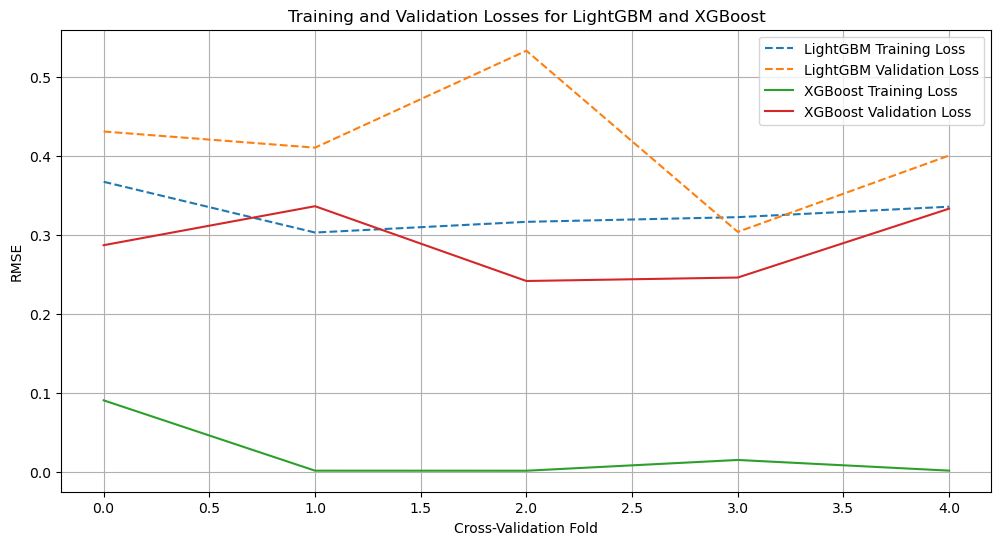

              RMSE       MAE        R2
LightGBM  0.430993  0.316641  0.848216
XGBoost   0.299613  0.247615  0.926649


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, r2_score
import lightgbm as lgb
import xgboost as xgb

# Define root_mean_squared_error function if not defined
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

# Create a synthetic dataset
np.random.seed(42)
X_synthetic = pd.DataFrame({
    "feature1": np.random.rand(100),
    "feature2": np.random.rand(100),
    "feature3": np.random.rand(100)
})
y_synthetic = X_synthetic["feature1"] * 3 + X_synthetic["feature2"] * 2 + np.random.normal(0, 0.1, 100)

# Train-validation-test split
X_train, X_temp, y_train, y_temp = train_test_split(X_synthetic, y_synthetic, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

def train_and_evaluate_model(model_name, model_class, params, X_train, y_train, X_val, y_val):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    train_losses, val_losses = [], []
    best_model = None
    best_rmse = float('inf')
    
    for train_index, val_index in kf.split(X_train):
        X_t, X_v = X_train.iloc[train_index], X_train.iloc[val_index]
        y_t, y_v = y_train.iloc[train_index], y_train.iloc[val_index]
        
        # Initialize the model
        if model_name == "LightGBM":
            # LightGBM model
            model = model_class(**params)
            model.fit(
                X_t, y_t,
                eval_set=[(X_v, y_v)],
                eval_metric="rmse",
                callbacks=[lgb.early_stopping(5)]
            )
            
        elif model_name == "XGBoost":
            # XGBoost model - specify early_stopping_rounds in params
            # Also add eval_metric to params as required
            params["eval_metric"] = "rmse"  
            model = model_class(**params)
            # For XGBoost v2.0+, early_stopping_rounds is set in constructor, not in fit
            model.fit(
                X_t, y_t,
                eval_set=[(X_v, y_v)],
                verbose=False
            )
        
        # Evaluate training and validation performance
        y_t_pred = model.predict(X_t)
        y_v_pred = model.predict(X_v)
        
        train_loss = root_mean_squared_error(y_t, y_t_pred)
        val_loss = root_mean_squared_error(y_v, y_v_pred)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        if val_loss < best_rmse:
            best_rmse = val_loss
            best_model = model
    
    # Final evaluation on the validation set
    y_val_pred = best_model.predict(X_val)
    final_val_rmse = root_mean_squared_error(y_val, y_val_pred)
    
    return {
        "model": best_model,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "final_val_rmse": final_val_rmse
    }

# Define parameters
lgb_params = {"objective": "regression", "metric": "rmse", "verbose": -1}
xgb_params = {
    "objective": "reg:squarederror", 
    "eval_metric": "rmse", 
    "verbosity": 0, 
    "early_stopping_rounds": 5
}

# Train LightGBM and XGBoost models
lgb_results = train_and_evaluate_model("LightGBM", lgb.LGBMRegressor, lgb_params, X_train, y_train, X_val, y_val)
xgb_results = train_and_evaluate_model("XGBoost", xgb.XGBRegressor, xgb_params, X_train, y_train, X_val, y_val)

# Plot training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(lgb_results["train_losses"], label="LightGBM Training Loss", linestyle="--")
plt.plot(lgb_results["val_losses"], label="LightGBM Validation Loss", linestyle="--")
plt.plot(xgb_results["train_losses"], label="XGBoost Training Loss", linestyle="-")
plt.plot(xgb_results["val_losses"], label="XGBoost Validation Loss", linestyle="-")
plt.xlabel("Cross-Validation Fold")
plt.ylabel("RMSE")
plt.title("Training and Validation Losses for LightGBM and XGBoost")
plt.legend()
plt.grid()
plt.show()

# Test evaluation
lgb_test_pred = lgb_results["model"].predict(X_test)
xgb_test_pred = xgb_results["model"].predict(X_test)

test_results = {
    "LightGBM": {
        "RMSE": root_mean_squared_error(y_test, lgb_test_pred),
        "MAE": mean_absolute_error(y_test, lgb_test_pred),
        "R2": r2_score(y_test, lgb_test_pred)
    },
    "XGBoost": {
        "RMSE": root_mean_squared_error(y_test, xgb_test_pred),
        "MAE": mean_absolute_error(y_test, xgb_test_pred),
        "R2": r2_score(y_test, xgb_test_pred)
    }
}

# Display test results
test_results_df = pd.DataFrame(test_results).T
print(test_results_df)
